### composites of ALL MEASURES classifications for the CSET region, with and without regional filters

In [2]:
import sys
sys.path.insert(0, '/home/disk/p/jkcm/Code')
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import utils 
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
from Lagrangian_CSET import met_utils as mu
import multiprocessing as mp
from tools.LoopTimer import LoopTimer
from Lagrangian_CSET import utils as LC_utils
%load_ext autoreload
%autoreload 2


The way we're going to go about this is to take the classifications and interpolate them to the MERRA grid, using a nearest-neighbor approach. We'll also store the original lat/lon on this regular grid, because why not.

In [2]:
cset_class_df = utils.load_class_data('cset')

In [3]:
#MERRA_data = xr.open_mfdataset(sorted(glob.glob(r'/home/disk/eos4/jkcm/Data/CSET/MERRA/unified_2/*.unified*.nc4')), combine='by_coords')
MERRA2_data =  xr.open_mfdataset(sorted(glob.glob(r'/home/disk/eos4/jkcm/Data/CSET/MERRA/pressure/*.inst3_3d_asm_Np*.nc')), combine='by_coords')
MERRA2_data = MERRA2_data.assign_coords(lon=MERRA2_data.lon.values%360)

In [5]:
MERRA2_sfc = xr.open_mfdataset(sorted(glob.glob(r'/home/disk/eos4/jkcm/Data/CSET/MERRA/sfc/*.inst*.nc')), combine='by_coords')
MERRA2_sfc = MERRA2_sfc.assign_coords(lon=MERRA2_sfc.lon.values%360)
time_arr = [True if i in MERRA2_data.time.values else False for i in MERRA2_sfc.time.values]
MERRA2_sfc_subs = MERRA2_sfc.isel(time=time_arr)
MERRA2_data['SST'] = MERRA2_sfc_subs['TS']
MERRA2_data['U10M'] = MERRA2_sfc_subs['U10M']
MERRA2_data['V10M'] = MERRA2_sfc_subs['V10M']


#ADD SOME MORE MERRA VARS
t_1000 = MERRA2_data.T.sel(lev=1000)
theta_700 = mu.theta_from_p_T(p=700, T=MERRA2_data.T.sel(lev=700))
LTS = theta_700-t_1000
t_dew = t_1000-(100-100*MERRA2_data.RH.sel(lev=1000))/5
lcl = mu.get_LCL(t=t_1000, t_dew=t_dew, z=MERRA2_data.H.sel(lev=1000))
z_700 = MERRA2_data.H.sel(lev=700)
gamma_850 = mu.get_moist_adiabatic_lapse_rate(MERRA2_data.T.sel(lev=850), 850)
EIS = LTS - gamma_850*(z_700-lcl)
MERRA2_data['LTS'] = LTS
MERRA2_data['EIS'] = EIS

t_v = mu.tvir_from_T_w(MERRA2_data.T, MERRA2_data.QV)
rho = mu.density_from_p_Tv(MERRA2_data.lev*100, t_v)
MERRA2_data['dzdt'] = -MERRA2_data['OMEGA']/(9.81*rho)
MERRA2_data['sfc_subs_anom'] = MERRA2_data.dzdt.sel(lev=700) - MERRA2_data.dzdt.sel(lev=900)
MERRA2_data['subs_700'] = MERRA2_data.dzdt.sel(lev=700)


In [6]:
#ADDING SOME MERRA DIVERGENCE STUFFS     
dudi = np.gradient(MERRA2_data.U10M)[2]
dvdj = np.gradient(MERRA2_data.V10M)[1]
    
dlatdy = 360/4.000786e7  # degrees lat per meter y
def get_dlondx(lat) : return(360/(np.cos(np.deg2rad(lat))*4.0075017e7))
dlondx = get_dlondx(MERRA2_data.coords['lat'].values)
lat_spaces = np.diff(MERRA2_data.coords['lat'].values)
lon_spaces = np.diff(MERRA2_data.coords['lon'].values)    
assert(np.allclose(lat_spaces, 0.5, atol=0.01) and np.allclose(lon_spaces, 0.625, atol=0.05))
dlondi = np.mean(lon_spaces)
dlatdj = np.mean(lat_spaces)

dudx = dudi/dlondi*dlondx[None, :, None]
dvdy = dvdj/dlatdj*dlatdy

div = dudx + dvdy
MERRA2_data['sfc_div'] = (('time', 'lat', 'lon'), div)
MERRA2_data['sfc_div'] = MERRA2_data['sfc_div'].assign_attrs(
                {"long_name": "10m wind divergence",
                 "units": "s**-1",
                 "_FillValue": "NaN"})

In [25]:
MERRA_subset = MERRA2_data[['H', 'PS', 'SST', 'U10M', 'V10M', 'LTS', 'EIS', 'dzdt', 'sfc_subs_anom', 'sfc_div']]
MERRA_subset.to_netcdf('/home/disk/eos4/jkcm/Data/CSET/MERRA/measures/MERRA_unified_subset.nc')

In [ ]:
# GRID THE CLASS DF ON THE MERRA GRID
MERRA_gridded_cat = xr.full_like(MERRA2_data.PS, fill_value=np.nan, dtype=float)
MERRA_gridded_cat.load();
MERRA_gridded_cf = xr.full_like(MERRA2_data.PS, fill_value=np.nan, dtype=float)
MERRA_gridded_cf.load();
n_outside_range = []
lt = LoopTimer(len(cset_class_df))
latmin, latmax = min(MERRA2_data.lat.values)-0.5, max(MERRA2_data.lat.values)+0.5
lonmin, lonmax = min(MERRA2_data.lon.values)-0.5, max(MERRA2_data.lon.values)+0.5
timemin, timemax = min(MERRA2_data.time.values), max(MERRA2_data.time.values)
for i,x in cset_class_df.iterrows():
    lt.update()
    time = x.datetime
    if x.lat > latmax or x.lat< latmin or x.lon > lonmax or x.lon < lonmin or time > timemax or time < timemin:
        n_outside_range.append(i)
        continue
    nlat = MERRA2_data.lat.sel(lat=x.lat, method='nearest', tolerance=0.5)
    nlon = MERRA2_data.lon.sel(lon=x.lon, method='nearest', tolerance=0.5)
    try:
        ntime = MERRA2_data.time.sel(time=time, method='nearest', tolerance=dt.timedelta(hours=2))
    except KeyError:
        print(f'missing time {time}')
        continue
    MERRA_gridded_cat.loc[dict(lat=nlat, lon=nlon, time=ntime)] = x['cat']
    MERRA_gridded_cf.loc[dict(lat=nlat, lon=nlon, time=ntime)] = x['low_cf']

MERRA2_data['cat'] = MERRA_gridded_cat
MERRA2_data['low_cf'] = MERRA_gridded_cf
MERRA2_data['landmask'] = ~(MERRA2_data.PHIS>50).sum(axis=0).astype(bool)

In [217]:
MERRA2_data['SST_l2'] = MERRA2_data['SST'].copy(data=np.concatenate((MERRA2_data['SST'][2*8:,:,:],MERRA2_data['SST'][0:2*8,:,:])))
MERRA2_data['SST_l1'] = MERRA2_data['SST'].copy(data=np.concatenate((MERRA2_data['SST'][1*8:,:,:],MERRA2_data['SST'][0:1*8,:,:])))
MERRA2_data['EIS_l2'] = MERRA2_data['EIS'].copy(data=np.concatenate((MERRA2_data['EIS'][2*8:,:,:],MERRA2_data['EIS'][0:2*8,:,:])))
MERRA2_data['EIS_l1'] = MERRA2_data['EIS'].copy(data=np.concatenate((MERRA2_data['EIS'][1*8:,:,:],MERRA2_data['EIS'][0:1*8,:,:])))
MERRA2_data['sfc_div_l2'] = MERRA2_data['sfc_div'].copy(data=np.concatenate((MERRA2_data['sfc_div'][2*8:,:,:],MERRA2_data['sfc_div'][0:2*8,:,:])))
MERRA2_data['sfc_div_l1'] = MERRA2_data['sfc_div'].copy(data=np.concatenate((MERRA2_data['sfc_div'][1*8:,:,:],MERRA2_data['sfc_div'][0:1*8,:,:])))
MERRA2_data['subs_700_l2'] = MERRA2_data['subs_700'].copy(data=np.concatenate((MERRA2_data['subs_700'][2*8:,:,:],MERRA2_data['subs_700'][0:2*8,:,:])))
MERRA2_data['subs_700_l1'] = MERRA2_data['subs_700'].copy(data=np.concatenate((MERRA2_data['subs_700'][1*8:,:,:],MERRA2_data['subs_700'][0:1*8,:,:])))

Text(0.5, 1.1, 'MERRA sfc divergence by cloud type for CSET region')

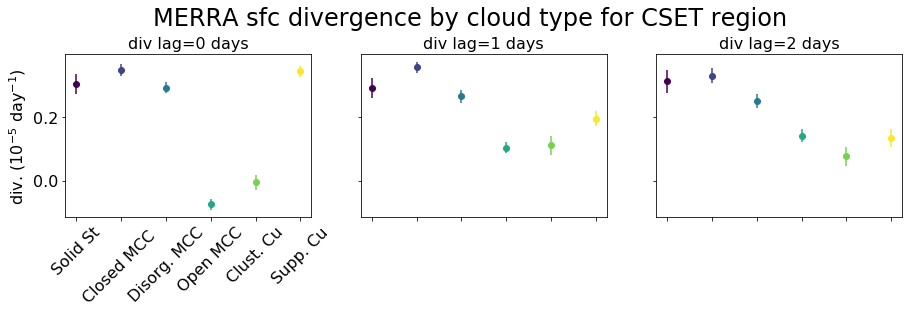

In [234]:
fig, ax = plt.subplots(figsize=(15, 3), ncols=3, sharey=True)
for axi, shift in zip(ax, ['0', '1', '2']):
    datavar = 'sfc_div' if shift=='0' else f'sfc_div_l{shift}'
    utils.plot_mean_by_cat_3d(MERRA2_data, datavar, verbose=False, bootstrap=True, ax=axi,
                       scale_factor=1e5)
    axi.set_title(f'div lag={shift} days')
ax[0].set_ylabel('div. (10$^{-5}$ day$^{-1}$)')
for i in [1,2]:
    ax[i].set_xticklabels(['']*6)
plt.suptitle('MERRA sfc divergence by cloud type for CSET region', y=1.1)

Text(0.5, 1.1, 'MERRA 700mb subs by cloud type for CSET region')

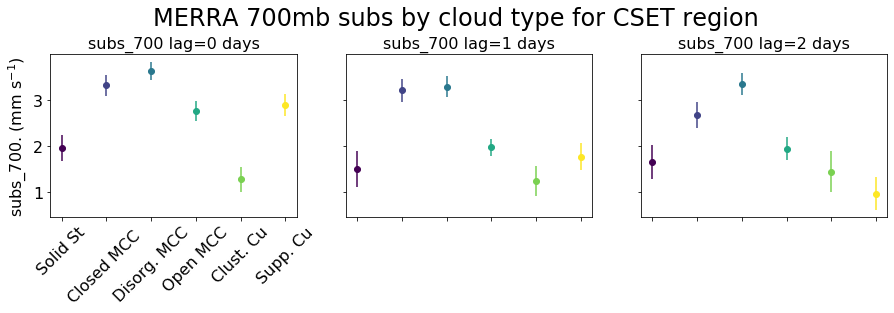

In [235]:
fig, ax = plt.subplots(figsize=(15, 3), ncols=3, sharey=True)
for axi, shift in zip(ax, ['0', '1', '2']):
    datavar = 'subs_700' if shift=='0' else f'subs_700_l{shift}'
    utils.plot_mean_by_cat_3d(MERRA2_data, datavar, verbose=False, bootstrap=True, ax=axi,
                       scale_factor=-1000)
    axi.set_title(f'subs_700 lag={shift} days')
ax[0].set_ylabel('subs_700. (mm s$^{-1}$)')
for i in [1,2]:
    ax[i].set_xticklabels(['']*6)
plt.suptitle('MERRA 700mb subs by cloud type for CSET region', y=1.1)

Text(0.5, 1.1, 'MERRA SST by cloud type for SEP region')

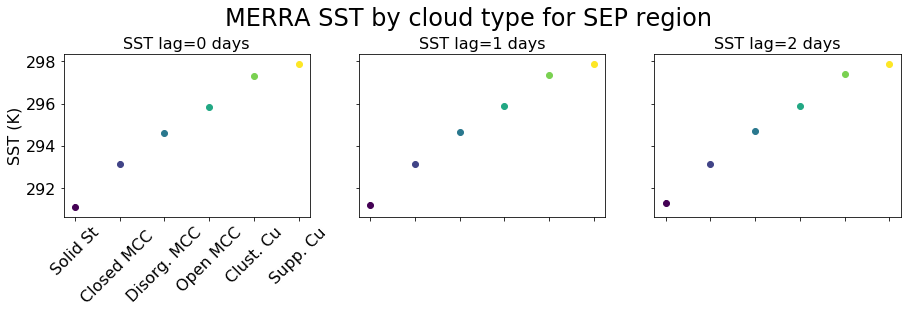

In [236]:
fig, ax = plt.subplots(figsize=(15, 3), ncols=3, sharey=True)
for axi, shift in zip(ax, ['0', '1', '2']):
    datavar = 'SST' if shift=='0' else f'SST_l{shift}'
    utils.plot_mean_by_cat_3d(MERRA2_data, datavar, verbose=False, bootstrap=True, ax=axi,
                       scale_factor=1)
    axi.set_title(f'SST lag={shift} days')
ax[0].set_ylabel('SST (K)')
for i in [1,2]:
    ax[i].set_xticklabels(['']*6)
plt.suptitle('MERRA SST by cloud type for SEP region', y=1.1)

Text(0.5, 1.1, 'MERRA EIS by cloud type for SEP region')

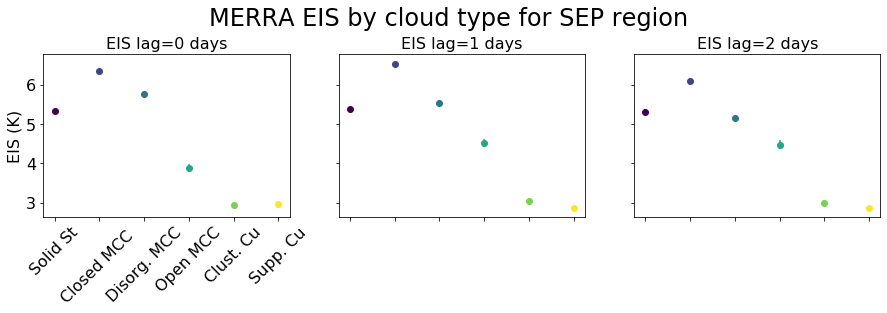

In [213]:
fig, ax = plt.subplots(figsize=(15, 3), ncols=3, sharey=True)
for axi, shift in zip(ax, ['0', '1', '2']):
    datavar = 'EIS' if shift=='0' else f'EIS_l{shift}'
    utils.plot_mean_by_cat_3d(MERRA2_data, datavar, verbose=False, bootstrap=False, ax=axi,
                       scale_factor=1)
    axi.set_title(f'EIS lag={shift} days')
ax[0].set_ylabel('EIS (K)')
for i in [1,2]:
    ax[i].set_xticklabels(['']*6)
plt.suptitle('MERRA EIS by cloud type for SEP region', y=1.1)

In [9]:
nd_file = r'/home/disk/eos15/robwood/Grosvenor/Nd37_2015_SZA_LT_65_CF_GT_80_CTH_LT_3.2km.nc'
nd_data = xr.open_dataset(nd_file)
nd_data = nd_data.rename_dims(dim_180='latitude', dim_360='longitude', dim_365='time')
nd_data = nd_data.rename(lat='latitude', lon='longitude')
nd_data = nd_data.drop('time_vec')
nd_data = nd_data.set_coords(names=['latitude', 'longitude', 'time'])
nd_data = nd_data.Nd
nd_data = nd_data.sel(longitude=slice(-180, -1))
nd_data = nd_data.assign_coords(longitude=nd_data.longitude.values%360)
#nd data: 1x1 degree, global, all of 2015, daily


In [10]:
nd_lat = nd_data.latitude.values
nd_lat = nd_lat[np.logical_and(nd_lat>min(MERRA2_data.lat.values), nd_lat<max(MERRA2_data.lat.values))]
nd_lon = nd_data.longitude.values
nd_lon = nd_lon[np.logical_and(nd_lon>min(MERRA2_data.lon.values), nd_lon<max(MERRA2_data.lon.values))]
MERRA2_lowres = MERRA2_data.interp(lat=nd_lat, lon=nd_lon, method='linear')

In [11]:
# GRID THE CLASS DF ON THE MERRA GRID LOWRES
MERRA_gridded_cat = xr.full_like(MERRA2_lowres.PS, fill_value=np.nan, dtype=float)
MERRA_gridded_cat.load();
MERRA_gridded_cf = xr.full_like(MERRA2_lowres.PS, fill_value=np.nan, dtype=float)
MERRA_gridded_cf.load();
n_outside_range = []
lt = LoopTimer(len(cset_class_df))
latmin, latmax = min(MERRA2_lowres.lat.values)-0.5, max(MERRA2_lowres.lat.values)+0.5
lonmin, lonmax = min(MERRA2_lowres.lon.values)-0.5, max(MERRA2_lowres.lon.values)+0.5
timemin, timemax = min(MERRA2_lowres.time.values), max(MERRA2_lowres.time.values)
for i,x in cset_class_df.iterrows():
    lt.update()
    time = x.datetime
    if x.lat > latmax or x.lat< latmin or x.lon > lonmax or x.lon < lonmin or time > timemax or time < timemin:
        n_outside_range.append(i)
        continue
    nlat = MERRA2_lowres.lat.sel(lat=x.lat, method='nearest', tolerance=0.5)
    nlon = MERRA2_lowres.lon.sel(lon=x.lon, method='nearest', tolerance=0.5)
    try:
        ntime = MERRA2_lowres.time.sel(time=time, method='nearest', tolerance=dt.timedelta(hours=2))
    except KeyError:
        print(f'missing time {time}')
        continue
    MERRA_gridded_cat.loc[dict(lat=nlat, lon=nlon, time=ntime)] = x['cat']
    MERRA_gridded_cf.loc[dict(lat=nlat, lon=nlon, time=ntime)] = x['low_cf']

MERRA2_lowres['cat'] = MERRA_gridded_cat
MERRA2_lowres['low_cf'] = MERRA_gridded_cf
MERRA2_lowres['landmask'] = ~(MERRA2_lowres.PHIS>50).sum(axis=0).astype(bool)

100.00%      ETA 23:40:20      time left: 0 seconds                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [12]:
nd_merra_space = nd_data.interp(longitude=MERRA2_lowres.lon.values, latitude=MERRA2_lowres.lat.values)
nd_merra_time = nd_merra_space.interp(time=MERRA2_lowres.time.values, method='nearest')
MERRA2_lowres['Nd'] = (('time', 'lat', 'lon'), np.transpose(nd_merra_time.values))

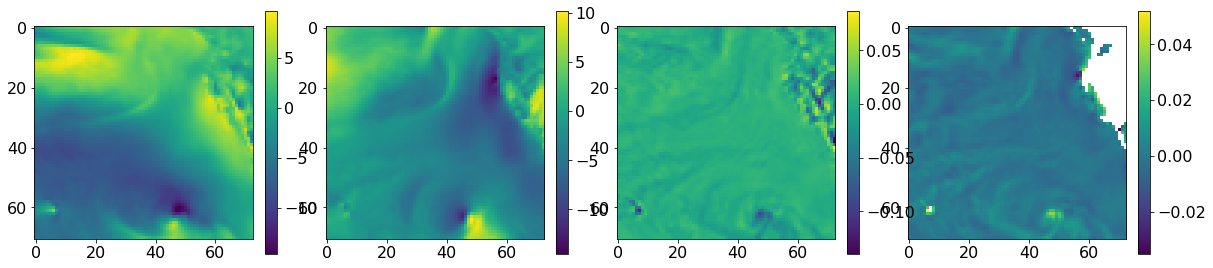

In [13]:
tidx = 400
fig, [ax1, ax2, ax3, ax4] = plt.subplots(ncols=4, figsize=(20,10))
i1 = ax1.imshow(MERRA2_data.U10M[tidx,::-1,:])
i2 = ax2.imshow(MERRA2_data.V10M[tidx,::-1,:])
i3 = ax3.imshow(div[tidx,::-1,:]*1000)
i4 = ax4.imshow(MERRA2_data.dzdt.sel(lev=slice(975, 950)).mean(dim='lev')[tidx,::-1,:])

for i, a in zip([i1, i2, i3, i4], [ax1, ax2, ax3, ax4]):
    plt.colorbar(i, ax=a, fraction=0.05)

In [14]:
#LOADING SCATTEROMETER DATA
scat_data = xr.open_mfdataset(sorted(glob.glob(r'/home/disk/eos9/jkcm/Data/ascat/rss/2015/all/*.nc')))
rho = scat_data.windspd.values
phi = scat_data.winddir.values
x = rho*np.cos(np.deg2rad((-phi+90)%360))
y = rho*np.sin(np.deg2rad((-phi+90)%360))

In [15]:
#THIS DOESN'T WORK with the ASCAT stupid-ass time axis
# #ADDING SOME SCAT DIVERGENCE STUFFS   

# dudi_s = np.gradient(x)[3]
# dvdj_s = np.gradient(y)[2]
    
# dlatdy_s = 360/4.000786e7  # degrees lat per meter y
# def get_dlondx(lat) : return(360/(np.cos(np.deg2rad(lat))*4.0075017e7))
# dlondx_s = get_dlondx(scat_data.coords['latitude'].values)
# lat_spaces_s = np.diff(scat_data.coords['latitude'].values)
# lon_spaces_s = np.diff(scat_data.coords['longitude'].values)    
# assert(np.allclose(lat_spaces_s, 0.25, atol=0.01) and np.allclose(lon_spaces_s, 0.25, atol=0.05))
# dlondi_s = np.mean(lon_spaces_s)
# dlatdj_s = np.mean(lat_spaces_s)

# dudx_s = dudi_s/dlondi_s*dlondx_s[None, None, :, None]
# dvdy_s = dvdj_s/dlatdj_s*dlatdy_s

# div_s = dudx_s + dvdy_s
# scat_data['div'] = (('time', 'orbit_segment', 'lat', 'lon'), div_s)
# scat_data['div'] = scat_data['div'].assign_attrs(
#                 {"long_name": "scatterometer divergence",
#                  "units": "s**-1",
#                  "_FillValue": "NaN"})

In [ ]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(10,5))

divmean = np.nanmean(div_s, axis=(0,1))
p = ax1.imshow(divmean[::-1,:]*1e5, vmin=-2, vmax=2, cmap='bwr')
plt.colorbar(p, ax=ax1)
meanx = np.nanmean(x, axis=(0,1))
meany = np.nanmean(y, axis=(0,1))
ax2.quiver(meanx[::20,::20],meany[::20,::20])

In [188]:
MERRA2_center = MERRA2_data.sel(lat=slice(20, 40), lon=slice(-150%360, -130%360))

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faa38327e48>)

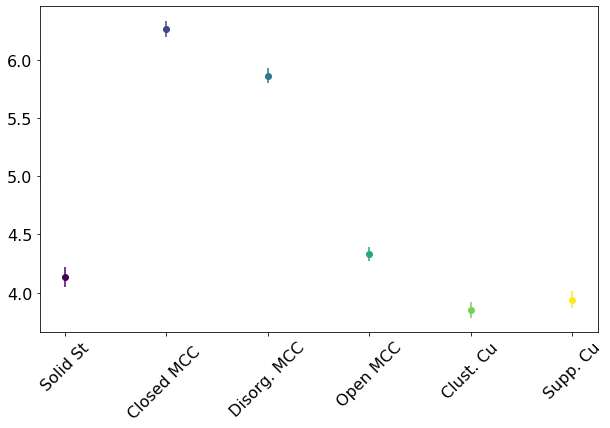

In [239]:
#     datavar = 'EIS' if shift=='0' else f'EIS_l{shift}'
utils.plot_mean_by_cat_3d(MERRA2_center, 'EIS', verbose=False, bootstrap=True,
                       scale_factor=1)

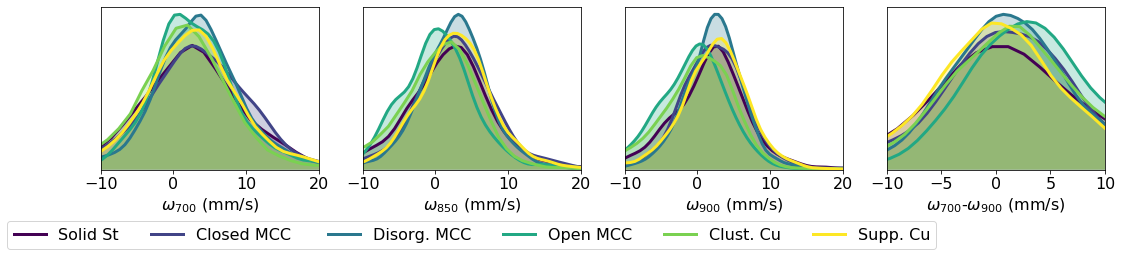

In [316]:
#PLOT SUBS AT DIFFERENT LEVS. LOOK AT PEAK SEPARATION BETWEEN CLUST AND SUPP
#ALSO SUBSET FOR CENTRAL REGION
fig, [ax1, ax2, ax3, ax4] = plt.subplots(figsize=(18, 3), nrows=1, ncols=4)
utils.plot_MERRA2_var_dists(MERRA2_data, varname='dzdt', lev=700, xlims=(-10, 20), xlabel='$\omega_{700}$ (mm/s)', 
                      ax=ax1, scale=-1000, savename=None, verbose=False)#, filt=(1,2,5))
utils.plot_MERRA2_var_dists(MERRA2_data, varname='dzdt', lev=850, xlims=(-10, 20), xlabel='$\omega_{850}$ (mm/s)', 
                      ax=ax2, scale=-1000, savename=None, verbose=False)#, filt=(1,2,5))
utils.plot_MERRA2_var_dists(MERRA2_data, varname='dzdt', lev=900, xlims=(-10, 20), xlabel='$\omega_{900}$ (mm/s)', 
                      ax=ax3, scale=-1000, savename=None, verbose=False)#, filt=(1,2,5));
utils.plot_MERRA2_var_dists(MERRA2_data, varname='sfc_subs_anom', xlims=(-10, 10), xlabel='$\omega_{700}$-$\omega_{900}$ (mm/s)', 
                      ax=ax4, scale=-1000, savename=None, verbose=False)#, filt=(1,2,5));
fig.subplots_adjust(hspace=0.4)
for axi in [ax1, ax2, ax3, ax4]:
    axi.get_legend().remove()
    axi.get_yaxis().set_ticks([])
    axi.set_ylabel('')
    
ax2.legend(loc='center', bbox_to_anchor=(0.5, -0.4), ncol=6)

In [ ]:
good_idx = ~np.isnan(MERRA2_data.cat)
all_CF = MERRA2_data.low_cf.where(good_idx).values.flatten()
all_EIS = MERRA2_data.EIS.where(good_idx).values.flatten()
plt.scatter(all_EIS, all_CF, s=1)

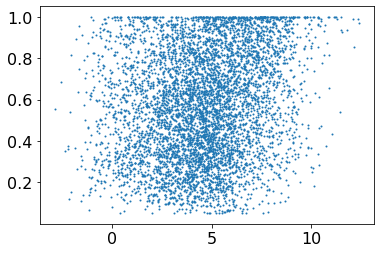

In [300]:
good_idx = ~np.isnan(MERRA2_center.cat)
all_CF = MERRA2_center.low_cf.where(good_idx).values.flatten()
all_EIS = MERRA2_center.EIS.where(good_idx).values.flatten()
plt.scatter(all_EIS, all_CF, s=1)
# plt.xlabel(

Text(0.5, 1.0, 'all')

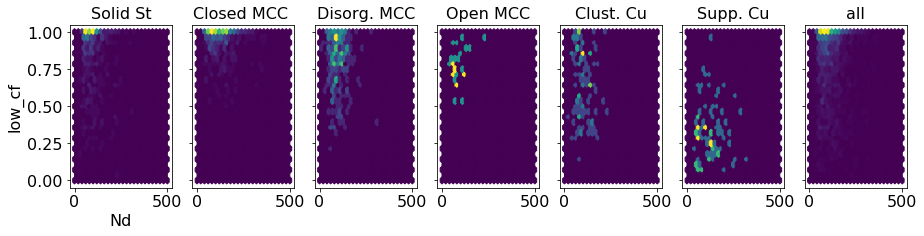

In [310]:
dataset = MERRA2_lowres
varx = 'Nd'
vary = 'low_cf'


colors = [mpl.cm.get_cmap('viridis')(i) for i in np.linspace(0,1,6)]
ordering = [4, 0, 2, 3, 1, 5]
labels = utils.short_labels
fig, ax = plt.subplots(ncols=len(ordering)+1, figsize=(15, 3), sharex=True, sharey=True)
for i, name in enumerate(ordering):
    good_idx = dataset.cat == name
    all_vary = dataset[vary].where(good_idx).values.flatten()
    all_varx = dataset[varx].where(good_idx).values.flatten()
#     ax[i].scatter(all_varx, all_vary, s=1, c=colors[i])
    ax[i].hexbin(all_varx, all_vary, gridsize=25, extent=(0, 500, 0, 1))#, gridsize=30)


    ax[i].set_title(labels[name])
ax[0].set_xlabel(varx)
ax[0].set_ylabel(vary)

good_idx = ~np.isnan(dataset.cat)
all_varx = dataset[varx].where(good_idx).values.flatten()
all_vary = dataset[vary].where(good_idx).values.flatten()
# ax[-1].scatter(all_varx, all_vary, s=1, c='k')
ax[-1].hexbin(all_varx, all_vary, gridsize=25, extent=(0, 500, 0, 1))
ax[-1].set_title('all')
# plt.xscale('log')


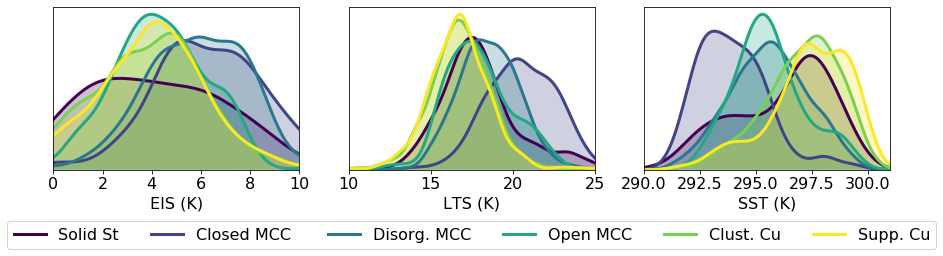

In [77]:
fig, [ax1, ax2, ax3] = plt.subplots(figsize=(15, 3), nrows=1, ncols=3)

utils.plot_MERRA2_var_dists(MERRA2_center, varname='EIS', xlims=(0, 10), xlabel='EIS (K)', 
                      ax=ax1, scale=1, savename=None, verbose=False)
utils.plot_MERRA2_var_dists(MERRA2_center, varname='LTS', xlims=(10, 25), xlabel='LTS (K)', 
                      ax=ax2, scale=1, savename=None, verbose=False)
utils.plot_MERRA2_var_dists(MERRA2_center, varname='SST', xlims=(290, 301), xlabel='SST (K)',
                      ax=ax3, scale=1, savename=None, verbose=False);

fig.subplots_adjust(hspace=0.4)
for axi in [ax1, ax2, ax3]:
    axi.get_legend().remove()
    axi.get_yaxis().set_ticks([])
    axi.set_ylabel('')
    
ax2.legend(loc='center', bbox_to_anchor=(0.5, -0.4), ncol=6)

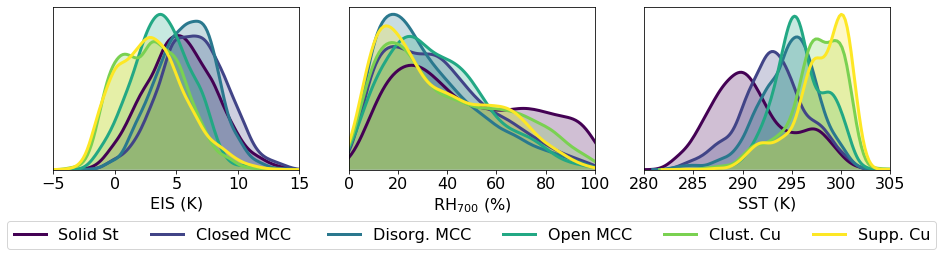

In [283]:
fig, [ax1, ax2, ax3] = plt.subplots(figsize=(15, 3), nrows=1, ncols=3)

utils.plot_MERRA2_var_dists(MERRA2_data, varname='EIS', xlims=(-5, 15), xlabel='EIS (K)', 
                      ax=ax1, scale=1, savename=None, verbose=False)
utils.plot_MERRA2_var_dists(MERRA2_data, varname='RH', lev=700, xlims=(0, 100), xlabel='RH$_{700}$ (%)', 
                      ax=ax2, scale=100, savename=None, verbose=False)
utils.plot_MERRA2_var_dists(MERRA2_data, varname='SST', xlims=(280, 305), xlabel='SST (K)',
                      ax=ax3, scale=1, savename=None, verbose=False);

fig.subplots_adjust(hspace=0.4)
for axi in [ax1, ax2, ax3]:
    axi.get_legend().remove()
    axi.get_yaxis().set_ticks([])
    axi.set_ylabel('')
    
ax2.legend(loc='center', bbox_to_anchor=(0.5, -0.4), ncol=6)

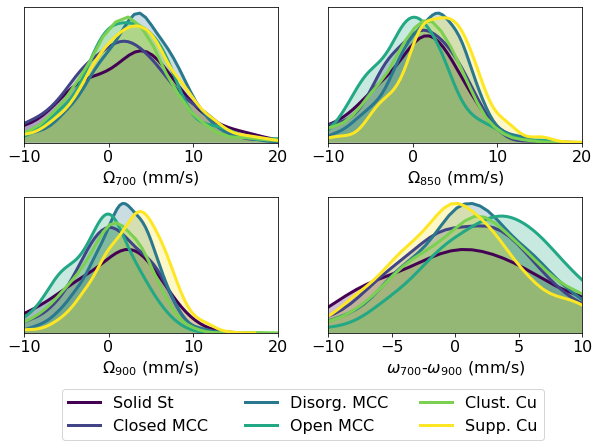

In [317]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
# fig, [ax1, ax2, ax3, ax4] = plt.subplots(figsize=(14, 3), nrows=2, ncols=4)
utils.plot_MERRA2_var_dists(MERRA2_center, varname='dzdt', lev=700, xlims=(-10, 20), xlabel='$\Omega_{700}$ (mm/s)', 
                      ax=ax1, scale=-1000, savename=None, verbose=False)
utils.plot_MERRA2_var_dists(MERRA2_center, varname='dzdt', lev=850, xlims=(-10, 20), xlabel='$\Omega_{850}$ (mm/s)', 
                      ax=ax2, scale=-1000, savename=None, verbose=False)
utils.plot_MERRA2_var_dists(MERRA2_center, varname='dzdt', lev=900, xlims=(-10, 20), xlabel='$\Omega_{900}$ (mm/s)', 
                      ax=ax3, scale=-1000, savename=None, verbose=False);
# utils.plot_MERRA2_var_dists(MERRA2_center, varname='sfc_div',xlims=(-2, 2), xlabel='10m wind div. (10$^{-5}$ s$^{-1}$)', 
#                       ax=ax4, scale=1e5, savename=None, verbose=False);
utils.plot_MERRA2_var_dists(MERRA2_center, varname='sfc_subs_anom', xlims=(-10, 10), xlabel='$\omega_{700}$-$\omega_{900}$ (mm/s)', 
                      ax=ax4, scale=-1000, savename=None, verbose=False)
fig.subplots_adjust(hspace=0.4)
for axi in [ax1, ax2, ax3, ax4]:
    axi.get_legend().remove()
    axi.get_yaxis().set_ticks([])
    axi.set_ylabel('')
    
ax3.legend(loc='center', bbox_to_anchor=(1.1, -0.6), ncol=3)

In [ ]:
# fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
fig, [ax1, ax2, ax3] = plt.subplots(figsize=(14, 3), nrows=1, ncols=3)
plot_MERRA2_var_dists(MERRA2_data, varname='sfc_div', xlims=(-10, 20), xlabel='$\Omega_{700}$ (mm/s)', 
                      ax=ax1, scale=-1000, savename=None, verbose=False)
plot_MERRA2_var_dists(MERRA2_data, varname='dzdt', lev=850, xlims=(-10, 20), xlabel='$\Omega_{850}$ (mm/s)', 
                      ax=ax2, scale=-1000, savename=None, verbose=False)
plot_MERRA2_var_dists(MERRA2_data, varname='dzdt', lev=900, xlims=(-10, 20), xlabel='$\Omega_{900}$ (mm/s)', 
                      ax=ax3, scale=-1000, savename=None, verbose=False);
fig.subplots_adjust(hspace=0.4)
for axi in [ax1, ax2, ax3]:#, ax4]:
    axi.get_legend().remove()
    axi.get_yaxis().set_ticks([])
    axi.set_ylabel('')
    
ax2.legend(loc='center', bbox_to_anchor=(0.5, -0.4), ncol=6)

In [98]:
def add_MERRA_profile(lat, lon, date, MERRA_data):
    col = MERRA_data.sel(lon=lon, lat=lat, time=date, method='nearest')
    col = col.assign_coords(dict(lev=col['PL']/100))
    return col

In [124]:
def MERRA_EIS(lat, lon, date, MERRA_data=MERRA_data):
    col = MERRA_data.sel(lon=lon, lat=lat, time=date, method='nearest')
    col = col.assign_coords(dict(lev=col['PL']/100))
    t_1000 = col['T'].interp(lev=1000).values
    t_850 = col['T'].interp(lev=850).values
    t_700 = col['T'].interp(lev=700).values
    z_1000 = col['H'].interp(lev=1000).values
    z_700 = col['H'].interp(lev=700).values
    r_1000 = col['RH'].interp(lev=1000).values*100
    EIS =  mu.calculate_EIS(t_1000, t_850, t_700, z_1000, z_700, r_1000)
    return EIS

## BELOW THIS IS NO MERRA

In [103]:
nd_file = r'/home/disk/eos15/robwood/Grosvenor/Nd37_2015_SZA_LT_65_CF_GT_80_CTH_LT_3.2km.nc'
nd_data = xr.open_dataset(nd_file)
nd_data = nd_data.rename_dims(dim_180='latitude', dim_360='longitude', dim_365='time')
nd_data = nd_data.rename(lat='latitude', lon='longitude')

nd_data = nd_data.drop('time_vec')
nd_data = nd_data.set_coords(names=['latitude', 'longitude', 'time'])
# nd_data = nd_data.Nd
nd_data = nd_data.sel(longitude=slice(-180, -1))
nd_data = nd_data.assign_coords(longitude=nd_data.longitude.values%360)
#nd data: 1x1 degree, global, all of 2015, daily

nd_cset = nd_data.sel(time=slice('2015-07-01', '2015-09-30'))

In [106]:
# GRID THE CLASS DF ON THE ND GRID
Nd_gridded_cat = xr.full_like(nd_cset.Nd, fill_value=np.nan, dtype=float)
Nd_gridded_cat.load();
Nd_gridded_cf = xr.full_like(nd_cset.Nd, fill_value=np.nan, dtype=float)
Nd_gridded_cf.load();
lt = LoopTimer(len(cset_class_df))
timemin, timemax = min(nd_cset.time.values), max(nd_cset.time.values)
for i,x in cset_class_df.iterrows():
    lt.update()
    time = x.datetime
    if time > timemax or time < timemin:
        continue
    nlat = nd_cset.latitude.sel(latitude=x.lat, method='nearest', tolerance=0.5)
    nlon = nd_cset.longitude.sel(longitude=x.lon%360, method='nearest', tolerance=0.5)
    try:
        ntime = nd_cset.time.sel(time=time, method='nearest', tolerance=dt.timedelta(hours=12))
    except KeyError:
        print(f'missing time {time}')
        continue
    Nd_gridded_cat.loc[dict(latitude=nlat, longitude=nlon, time=ntime)] = x['cat']
    Nd_gridded_cf.loc[dict(latitude=nlat, longitude=nlon, time=ntime)] = x['low_cf']

nd_cset['cat'] = Nd_gridded_cat
nd_cset['low_cf'] = Nd_gridded_cf
# nd_cset['landmask'] = ~(MERRA2_data.PHIS>50).sum(axis=0).astype(bool)

100.00%      ETA 09:48:12      time left: 0 seconds                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [1]:
amsr_file = r'/home/disk/eos9/jkcm/Data/amsr/AMSR2_CWV_CSET.nc'
amsr_data = xr.open_dataset(amsr_file)
amsr_data = amsr_data.rename_dims(Latitude='latitude', Longitude='longitude', Time='time')
amsr_data = amsr_data.set_coords(names=['latitude', 'longitude'])
amsr_data['day'] = amsr_data.day.where(np.logical_not(amsr_data.day==0), other=np.nan)
amsr_data['CWV'] = amsr_data.CWV.where(np.logical_not(amsr_data.CWV==0), other=np.nan)

amsr_data['time'] = (('time'), amsr_data.day.mean(dim=['latitude', 'longitude']))
amsr_data.day.attrs['units'] = 'days since 2014-12-31'
amsr_data.time.attrs['units'] = 'days since 2014-12-31'
amsr_data = xr.decode_cf(amsr_data)
amsr_data2 = amsr_data.set_coords(names=['time'])
amsr_data2.to_netcdf(r'/home/disk/eos4/jkcm/Data/CSET/amsr/AMSR2_CWV_CSET_fixed.nc', unlimited_dims=['time'])

NameError: name 'xr' is not defined

In [98]:
# amsr_file = r'/home/disk/eos7/bloss/Runs/CSET/Plots/AMSR2_CWV_CSET.nc'
# amsr_data = xr.open_dataset(amsr_file)
# amsr_data = amsr_data.rename_dims(Latitude='latitude', Longitude='longitude', Time='time')
# amsr_data = amsr_data.set_coords(names=['latitude', 'longitude'])
# amsr_data['time'] = (('time'), amsr_data.day.mean(dim=['latitude', 'longitude']))
# amsr_data.day.attrs['units'] = 'days since 2014-12-31'
# amsr_data.time.attrs['units'] = 'days since 2014-12-31'
# amsr_data = xr.decode_cf(amsr_data)
# amsr_data = amsr_data.set_coords(names=['time'])

In [116]:
amsr_file = r'/home/disk/eos4/jkcm/Data/CSET/amsr/AMSR2_CWV_CSET_fixed.nc'
amsr_data2 = xr.open_dataset(amsr_file)


#amsr_data: 0.25x0.25 degree, CSET region, July/Sept 2015, daily
#lon = 180-260

In [100]:
ascat_files = [f'/home/disk/eos9/jkcm/Data/ascat/rss/all/ascat_unified_2015-{i}.nc' for i in ['07', '08', '09']]
ascat_data = xr.open_mfdataset(ascat_files)
ascat_data = utils.get_ascat_divergence(ascat_data)
ascat_data = ascat_data.sel(longitude=slice(181, 359), orbit_segment=0)
ascat_data=ascat_data.assign_coords(time=ascat_data.time + (ascat_data.mingmt.mean(axis=(1,2))*60*1e3).astype('timedelta64[ms]'))
# ascat_datetime = ascat_data.time
#ascat_data, 0.25x0.25 degree, global, July/Sept 2015, daily, two orbits

In [101]:
def stepped_interp(dataset, new_lats, new_lons, lat_name='latitude', lon_name='longitude'):
    new_res = np.mean(np.diff(new_lats))
    if not new_res == np.mean(np.diff(new_lats)):
        raise ValueError("yo man I'm probably going to fail on this regrid")
    old_res = np.mean(np.diff(dataset[lat_name]))
    if old_res>new_res:
        raise ValueError("bruh I'm regridding to a high lat, I'm not cut out for this")
    regrids = max(1, round(np.log2(new_res/old_res)))-1
    while(regrids>0):
        print(np.mean(np.diff(dataset[lat_name])), np.mean(np.diff(dataset[lon_name])))
        regrids-=1
        regrid_res = new_res/2
#         regrid_lats = np.sort(np.hstack((new_lats, (new_lats+regrid_res)[:-1])))
#         regrid_lats = np.sort(np.hstack((new_lats, (new_lats+regrid_res)[:-1])))
        regrid_lats = dataset[lat_name][::2]
        regrid_lons = dataset[lon_name][::2]
        dataset = dataset.interp({lat_name:regrid_lats,  lon_name:regrid_lons}, method='linear')
    print(np.mean(np.diff(dataset[lat_name])), np.mean(np.diff(dataset[lon_name])))
    dataset = dataset.interp({lat_name:new_lats,  lon_name:new_lons}, method='linear')
    print(np.mean(np.diff(dataset[lat_name])), np.mean(np.diff(dataset[lon_name])))
    return dataset

In [107]:
#regrid it all onto nd
nd_lat = nd_cset.latitude.values
nd_lon = nd_cset.longitude.values
nd_time = nd_cset.time.values

#regrid ascat onto nd
# ascat_div_ndspace = ascat_data.div.interp(latitude=nd_lat, longitude=nd_lon, method='linear')
ascat_div_ndspace = stepped_interp(ascat_data.div, nd_lat, nd_lon, lat_name='latitude', lon_name='longitude')

# ascat_div_ndspace = ascat_div_ndspace.sel(orbit_segment=0)
ascat_div_ndspacetime = ascat_div_ndspace.interp(time=nd_time, method='nearest')
nd_cset['ASCAT_DIV'] = ascat_div_ndspacetime.transpose()

#regrid amsr onto nd
# amsr_cwv_ndspace = amsr_data.CWV.interp(latitude=nd_lat, longitude=nd_lon, method='linear')
amsr_cwv_ndspace = stepped_interp(amsr_data.CWV, nd_lat, nd_lon, lat_name='latitude', lon_name='longitude')
amsr_cwv_ndspacetime = amsr_cwv_ndspace.interp(time=nd_time, method='nearest')
nd_cset['AMSR_CWV'] = amsr_cwv_ndspacetime.transpose()

amsr_cwv_ndspace2 = stepped_interp(amsr_data2.CWV, nd_lat, nd_lon, lat_name='latitude', lon_name='longitude')
amsr_cwv_ndspacetime2 = amsr_cwv_ndspace2.interp(time=nd_time, method='nearest')
nd_cset['AMSR_CWV_2'] = amsr_cwv_ndspacetime2.transpose()

0.25 0.25
0.5 0.5
1.0 1.0
0.25 0.25
0.5 0.5
1.0 1.0
0.25 0.25
0.5 0.5
1.0 1.0


ZeroDivisionError: 0.0 cannot be raised to a negative power

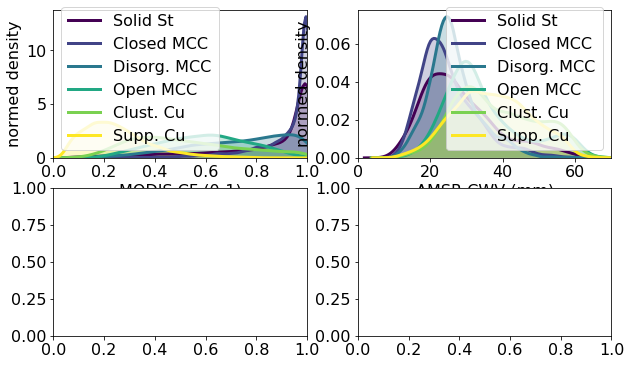

In [112]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
utils.plot_MERRA2_var_dists(nd_cset, varname='low_cf', xlims=(0, 1), xlabel='MODIS CF (0-1)', 
                      ax=ax1, scale=1, savename=None, verbose=False)
utils.plot_MERRA2_var_dists(nd_cset, varname='AMSR_CWV', xlims=(0, 70), xlabel='AMSR CWV (mm)', 
                      ax=ax2, scale=1, savename=None, verbose=False)
utils.plot_MERRA2_var_dists(nd_cset, varname='AMSR_CWV_2', xlims=(0, 70), xlabel='AMSR CWV (mm)', 
                      ax=ax3, scale=1, savename=None, verbose=False)
utils.plot_MERRA2_var_dists(nd_cset, varname='ASCAT_DIV',xlims=(-5, 5), xlabel='ASCAT 10m wind div. (10$^{-5}$ s$^{-1}$)', 
                      ax=ax4, scale=1e5, savename=None, verbose=False);
fig.subplots_adjust(hspace=0.4)
for axi in [ax1, ax2, ax3, ax4]:
    axi.get_legend().remove()
    axi.get_yaxis().set_ticks([])
    axi.set_ylabel('')
    
ax3.legend(loc='center', bbox_to_anchor=(1.1, -0.6), ncol=3)

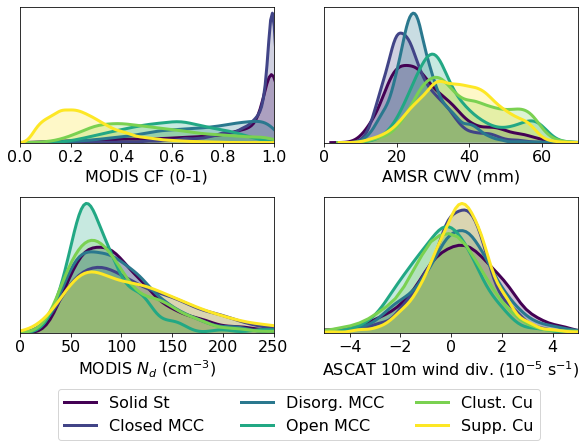

In [108]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(10, 6), nrows=2, ncols=2)
utils.plot_MERRA2_var_dists(nd_cset, varname='low_cf', xlims=(0, 1), xlabel='MODIS CF (0-1)', 
                      ax=ax1, scale=1, savename=None, verbose=False)
utils.plot_MERRA2_var_dists(nd_cset, varname='AMSR_CWV', xlims=(0, 70), xlabel='AMSR CWV (mm)', 
                      ax=ax2, scale=1, savename=None, verbose=False)
utils.plot_MERRA2_var_dists(nd_cset, varname='Nd', xlims=(0, 250), xlabel='MODIS $N_d$ (cm$^{-3}$)', 
                      ax=ax3, scale=1, savename=None, verbose=False);
utils.plot_MERRA2_var_dists(nd_cset, varname='ASCAT_DIV',xlims=(-5, 5), xlabel='ASCAT 10m wind div. (10$^{-5}$ s$^{-1}$)', 
                      ax=ax4, scale=1e5, savename=None, verbose=False);
fig.subplots_adjust(hspace=0.4)
for axi in [ax1, ax2, ax3, ax4]:
    axi.get_legend().remove()
    axi.get_yaxis().set_ticks([])
    axi.set_ylabel('')
    
ax3.legend(loc='center', bbox_to_anchor=(1.1, -0.6), ncol=3)

Solid St:, total:6166, usable:3093
       mean:28.28391503125, stderr:0.32928694089534416
Closed MCC :, total:3291, usable:2320
       mean:25.106036600000003, stderr:0.2748023555127893
Disorg. MCC:, total:4340, usable:3364
       mean:26.50354715625, stderr:0.19991685039907797
Open MCC:, total:839, usable:649
       mean:34.85786405046225, stderr:0.45400160100338155
Clust. Cu:, total:10805, usable:7647
       mean:38.19568960625, stderr:0.34869034667313153
Supp. Cu:, total:9936, usable:6707
       mean:37.22194451875, stderr:0.3046673306250129


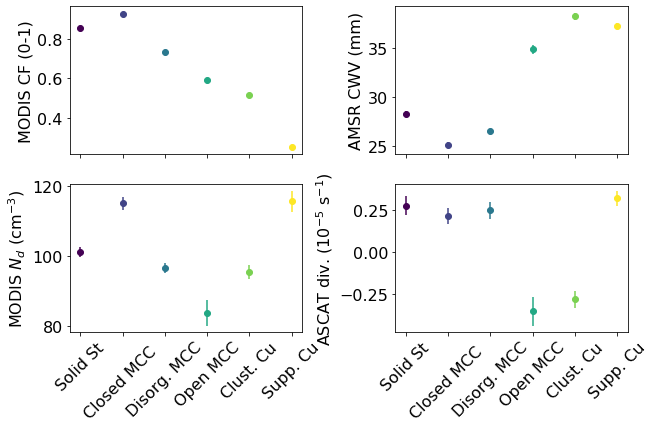

In [114]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(figsize=(10, 6), nrows=2, ncols=2, sharex=True)
utils.plot_mean_by_cat_3d(nd_cset, varname='low_cf', ylabel='MODIS CF (0-1)', 
                      ax=ax1, scale_factor=1, savename=None, verbose=False, bootstrap=True)
utils.plot_mean_by_cat_3d(nd_cset, varname='AMSR_CWV', ylabel='AMSR CWV (mm)', 
                      ax=ax2, scale_factor=1, savename=None, verbose=True, bootstrap=True)
utils.plot_mean_by_cat_3d(nd_cset, varname='Nd', ylabel='MODIS $N_d$ (cm$^{-3}$)', 
                      ax=ax3, scale_factor=1, savename=None, verbose=False, bootstrap=True);
utils.plot_mean_by_cat_3d(nd_cset, varname='ASCAT_DIV', ylabel='ASCAT div. (10$^{-5}$ s$^{-1}$)', 
                      ax=ax4, scale_factor=1e5, savename=None, verbose=False, bootstrap=True);
fig.subplots_adjust(wspace=0.4)
# for axi in [ax1, ax2, ax3, ax4]:
#     axi.get_legend().remove()
#     axi.get_yaxis().set_ticks([])
#     axi.set_ylabel('')
    
# ax3.legend(loc='center', bbox_to_anchor=(1.1, -0.6), ncol=3)

In [ ]:
cset_center = nd_cset.sel(lat=slice(20, 40), lon=slice(-150%360, -130%360))